### 1. TOKENIZATION

#### _1.1 Load text file_

In [1]:
with open("the-verdict.txt", "r", encoding = "utf-8") as t:
    raw_text = t.read()

print(f"Total number of characters: {len(raw_text)}")
print(raw_text[:99])

Total number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


#### _1.2 RE tokenizer_

In [2]:
import re

sample = "Hey, what's good?"
result = re.split(r'([,.:;?!"()\'/]|--|\s)', sample)

print(result)

['Hey', ',', '', ' ', 'what', "'", 's', ' ', 'good', '?', '']


In [3]:
result = [item for item in result if item.strip()] # retunrs false for whitespaces / no spaces
print(result)

['Hey', ',', 'what', "'", 's', 'good', '?']


Now, apply RE tokenizer to main text.

In [4]:
preprocessed = re.split(r'([.,:;?!"()\'/]|--|\s)', raw_text)
preprocessed = [item for item in preprocessed if item.split()]

print(f"Number of tokens: {len(preprocessed)}")
print(preprocessed[:30])

Number of tokens: 4654
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


#### _1.3 Token ID creation_

In [5]:
all_words = sorted(set(preprocessed))
print(f"Length of vocabulary: {len(all_words)}")

Length of vocabulary: 1139


In [6]:
vocab = {token:integer for integer, token in enumerate(all_words)}

for t, i in vocab.items():
    print(t, i)
    if i >= 20:
        break

! 0
" 1
' 2
( 3
) 4
, 5
-- 6
. 7
: 8
; 9
? 10
A 11
Ah 12
Among 13
And 14
Are 15
Arrt 16
As 17
At 18
Be 19
Begin 20


#### _1.4 Tokenizer class_

In [7]:
class TokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\'/]|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip() # remove white spaces
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join(self.int_to_str[i] for i in ids) # int_to_str gives back the text in a list. " ".join joins them into a normal sentence
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) # fixes space before punctuations
        return text

In [8]:
tokenizer = TokenizerV1(vocab)
s2i = tokenizer.encode("I HAD always thought.")
tokenizer.decode(s2i)

'I HAD always thought.'

#### _1.5 Special Context Tokens_

In [9]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(['<|endoftext|>', '<|unk|>'])

vocab = {token:integer for integer, token in enumerate(all_tokens)}
print(f"Length of vocabulary with special context tokens: {len(vocab.items())}")

Length of vocabulary with special context tokens: 1141


In [10]:
keys = []
for k, v in enumerate(vocab.keys()):
    keys.append(v)
print(keys[-5:])

['younger', 'your', 'yourself', '<|endoftext|>', '<|unk|>']


In [11]:
class TokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\'/]|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip() # remove white spaces
        ]
        # if item not in vocab, replace it with <|unk|> token
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]
        preprocessed.append("<|endoftext|>")
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join(self.int_to_str[i] for i in ids) # int_to_str gives back the text in a list. " ".join joins them into a normal sentence
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) # fixes space before punctuations
        return text

In [12]:
tokenizer = TokenizerV2(vocab)
s2i = tokenizer.encode("Hello, how are you doing?")
tokenizer.decode(s2i)

'<|unk|>, how are you doing? <|endoftext|>'

#### _1.6 Byte Pair Encoding_

In [13]:
import importlib
import tiktoken

In [14]:
tokenizer = tiktoken.get_encoding('gpt2')

In [15]:
text = "Hello, Ilham. <|endoftext|> Would you like a cupoftea?"
integers = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
print(integers)

[15496, 11, 13778, 2763, 13, 220, 50256, 10928, 345, 588, 257, 6508, 1659, 660, 64, 30]


In [16]:
strings = tokenizer.decode(integers)
print(strings)

Hello, Ilham. <|endoftext|> Would you like a cupoftea?


---

### 2. INPUT-TARGET PAIRS

In [17]:
with open("the-verdict.txt", "r", encoding = "utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print("Total number of tokens from byte pair encoding:", len(enc_text))

Total number of tokens from byte pair encoding: 5145


In [18]:
context_size = 5 # input will have 5 tokens
x = enc_text[:context_size]
y = enc_text[1:context_size + 1]
print(f"X: {x}")
print(f"y:     {y}")

X: [40, 367, 2885, 1464, 1807]
y:     [367, 2885, 1464, 1807, 3619]


#### _2.1 Using Dataloader_

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_len, stride): # max_len is context size
        self.input_ids = []
        self.target_ids = []

        # tokenize the text
        token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})

        # sliding window to create overlapping sequences
        for i in range(0, len(token_ids) - max_len, stride):
            input_chunk = token_ids[i:i + max_len]
            target_chunk = token_ids[i + 1:i + max_len + 1]
            self.input_ids.append(input_chunk)
            self.target_ids.append(target_chunk)
    
    # the below 2 methods is required for Dataloader to be used
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx): # we are basically saying that if the input is the 50th tensor, then the output is the 50th tensor
        return (
            torch.tensor(self.input_ids[idx], dtype=torch.long),
            torch.tensor(self.target_ids[idx], dtype=torch.long)
        )

The idea is to form something like as follows:<br><br>
[[1, 2, 3, 4],<br>
[5, 6, 7, 8],<br>
[9, 10, 11, 12]]<br><br>
[[2, 3, 4, 5],<br>
[6, 7, 8, 9],<br>
[10, 11, 12, 13]]<br><br>
...where the first matrix is X and the second matrix is y. Note that in the above example, the stride as well as the max length is 4. If the stride was 2:<br><br>
[[1, 2, 3, 4],<br>
[3, 4, 5, 6],<br>
[5, 6, 7, 8]]<br><br>
[[2, 3, 4, 5],<br>
[4, 5, 6, 7],<br>
[6, 7, 8, 9]]

In [20]:
def create_dataloader_v1(txt, batch_size = 4, max_len = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0):
    # drop last if last tensor is shorter than max_len
    # batch size is the number of training ip-op data pairs to be used for training by whcih the parameters are updated
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = GPTDatasetV1(txt, tokenizer, max_len, stride)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )
    return dataloader

In [21]:
with open("me.txt", "r", encoding = "utf-8") as f:
    raw_text = f.read()

In [22]:
import torch
dataloader = create_dataloader_v1(raw_text, batch_size = 1, max_len = 4, stride = 1, shuffle = False) # looking into how the function will work
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  464, 12556,  4062,   602]]), tensor([[12556,  4062,   602,   290]])]


Using a batch size of 1 is not preferred as this leads to noisy updates, even though good for memory.<br>
Note that a higher overlap (lower stride) can lead to overfitting.

---

### 3. VECTOR EMBEDDING

In [23]:
# sample

input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3 # embedding dimention

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim) # intialize mebedding matrix randomly
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [24]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


The embedding weight matrix is basically used for lookup operation.

In [25]:
print(embedding_layer(input_ids)) # looking up vector embeddings for the sample input

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


Note that this is essencially a one hot encoded represenation of the input IDs passed into a linear layer to get the output embeddings where the weights of the neural net are randomly initialized. But we dom't use this because it's not efficient due to the sparsity of the one hot encoded input matrix.

In [26]:
# sample two

vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [27]:
max_len = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size = 8, max_len = max_len,
    stride = max_len, shuffle = False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [28]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[  464, 12556,  4062,   602],
        [  290, 31421, 15120,   198],
        [  198,  2215,   530,  3073],
        [  379,   262, 22942,   286],
        [19773,  1081,   361, 22982],
        [24411,    11,   340,  4329],
        [ 1598,   326,   465,  3108],
        [  656,   262,   995,   286]])

Inputs shape:
 torch.Size([8, 4])


In [29]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


This is basically a batch of 8 with 4 tokens each, and each token is converted to a vector of dimention 256. 

---

### 4. POSITIONAL EMBEDDING

Now we create positional embedding the same way as we did for the token embeddings.

In [30]:
context_len = max_len # 4
pos_embedding_layer = torch.nn.Embedding(context_len, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(max_len)) # arange creates ids from 0 to max_len - 1 and pos_embedding_layer converts them to embedding matrix where each row corresponds to the positional embedding for that position id
print(pos_embeddings.shape)
print(pos_embeddings)

torch.Size([4, 256])
tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       grad_fn=<EmbeddingBackward0>)


So the first vector embedding of a 4 token sentence will always be added by the vector [1.7375, -0.5620, ..., 1.0345]

It must also be noted that each row will have the same set of positional embedding values. In other words, the PE value repeats for each row. So the final embedding matrix will only be 4x256 and not 8x4x256. We only care about the position in this case.

We can directly add the token and position embeddings, even though the dimentions don't match exactly via broadcasting.

In [31]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


---

### 5. SIMPLIFIED ATTENTION MECHANISM

In [32]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with
     [0.77, 0.25, 0.10], # one 
     [0.05, 0.80, 0.55]] # step
)

We know that attention scores are calculated by taking the dot product between the query token and all the other input tokens.

In [33]:
query = inputs[1] # let the query token be journey

attention_scores_x_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attention_scores_x_2[i] = torch.dot(x_i, query)

print(attention_scores_x_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [34]:
query

tensor([0.5500, 0.8700, 0.6600])

In [35]:
# now normalize the scores

attention_weights_x_2 = attention_scores_x_2 / attention_scores_x_2.sum()
print(attention_weights_x_2)
print(attention_weights_x_2.sum())

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
tensor(1.0000)


Note that attention __scores__ are not normalized, but attention __weights__ are, and they sum up to one.

In [36]:
# softmax normalization

def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim = 0)

attention_weights_x_2_naive_sm = softmax_naive(attention_scores_x_2) # sm: softmax
print(attention_weights_x_2_naive_sm)
print(attention_weights_x_2_naive_sm.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(1.)


PyTorch implementation of Softmax is preffered to control instability.

In [37]:
# pytorch softmax operation

attention_weights_x_2_pt_sm = torch.softmax(attention_scores_x_2, dim = 0) # pt: pytorch
print(attention_weights_x_2_pt_sm)
print(attention_weights_x_2_pt_sm.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(1.)


#### _5.1 Context vector calculation for 'journey'_

In [38]:
query = inputs[1]

context_vector_x2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vector_x2 += attention_weights_x_2_pt_sm[i] * x_i

print(context_vector_x2)

tensor([0.4419, 0.6515, 0.5683])


#### _5.2 Calculate attention matrix_

In [39]:
attention_scores = inputs @ inputs.T
print(attention_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


This can be done using 2 for loops but that's computationally very expensive. Rather, we can do the above transpose operation.

In [40]:
attention_weights = torch.softmax(attention_scores, dim = -1) 
print(attention_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


Setting dimention to -1 means it will normalize accross the columns. This is because the matrix dimention is n_row x n_col.

In [41]:
# context vectors calculation (z_i)

context_vectors = attention_weights @ inputs
print(context_vectors)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


---

### 6. SELF ATTENTION

In [42]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with
     [0.77, 0.25, 0.10], # one 
     [0.05, 0.80, 0.55]] # step
)

Now we randomly initialize W_q, W_k & W_v. Each of them will have dimentiones were the number of row count will be eqaul to the input vector dimention (column count of input matrix).

In [43]:
# we will be working with the sample word 'journey' again

x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2 # this will be the number of columns in the key, quey and value matrices

In [44]:
torch.manual_seed(123)

# set requires_grad to True later for model training
W_q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad = False)
W_k = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad = False)
W_v = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad = False)

print(W_q)
print(W_k)
print(W_v)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])
Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])
Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [45]:
# now we calculate the query, key and value for the sample input word 'journey'

q_2 = x_2 @ W_q
k_2 = x_2 @ W_k
v_2 = x_2 @ W_v

print(q_2)
print(k_2)
print(v_2)

tensor([0.4306, 1.4551])
tensor([0.4433, 1.1419])
tensor([0.3951, 1.0037])


Note that conventionally, just like how things were implemented in section 5, the output from these dot product operations must have the same dimention as the input vector. 

In [46]:
# get the overall query, key and value

query = inputs @ W_q
key = inputs @ W_k
value = inputs @ W_v

print(query)
print(key)
print(value)

tensor([[0.2309, 1.0966],
        [0.4306, 1.4551],
        [0.4300, 1.4343],
        [0.2355, 0.7990],
        [0.2983, 0.6565],
        [0.2568, 1.0533]])
tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])
tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.1492, 0.3346],
        [0.3221, 0.7863]])


Now we compute the attention scores. In self attention, this is essencially the dot product between the query and the key vectors.

In [47]:
# for 'journey':

query_2 = query[1]
key_2 = key[1]

attention_scores_2 = query_2 @ key.T
print(attention_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


This is basically saying how much the word __journey__ attends to all the other words. Obviously, this will be highest for the second word (itself).

In [48]:
# overall attention

attention_scores = query @ key.T
print(attention_scores)

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


For now, these don't mean anything because they are not trained. Next, we normalize these scores. We normalize by first scaling the scores by square root of d_out or embedding dimention of each word of the key matrix (number of columns). Next, we apply softmax over it.

In [49]:
# normalize to get attention weights (this is just for 'journey')

d_k = key.shape[1]
attention_weights_2 = torch.softmax(attention_scores_2 / d_k ** 0.5, dim = -1)
print(attention_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


Why take square root? Multiply any 2 numbers (here, we are multiplying the key and query) increases the variance. So to stabilize it back, we take the root. Another reason is for bringing stability to the softmax outputs and to have an even distribution. If not, the scores can get overly confident for a single input word. (Refer lecture 15, 46th minute for more detail).<br><br>
This is why self attention is also called __sclaed dot product attention__.

In [50]:
# get attention weights for enitre sentence

attention_weights = torch.softmax(attention_scores / d_k ** 0.5, dim = -1)
print(attention_weights)

tensor([[0.1551, 0.2104, 0.2059, 0.1413, 0.1074, 0.1799],
        [0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
        [0.1503, 0.2256, 0.2192, 0.1315, 0.0914, 0.1819],
        [0.1591, 0.1994, 0.1962, 0.1477, 0.1206, 0.1769],
        [0.1610, 0.1949, 0.1923, 0.1501, 0.1265, 0.1752],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])


These attentions weights are now multiplied with the _value_ matrix to get the __context vectors__.

In [51]:
context = attention_weights @ value
print(context)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]])


Now we make a self attention calss for further usage.

In [52]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_q = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_k = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_v = torch.nn.Parameter(torch.rand(d_in, d_out))
    
    def forward(self, x):
        keys = x @ self.W_k
        queries = x @ self.W_q
        values = x @ self.W_v

        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)

        context = attention_weights @ values
        return context

In [53]:
# test class

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [54]:
# version 2, which is more optimized due to the Linear class from PyTorch

class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias = False):
        super().__init__()
        self.W_q = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_k = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_v = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
    
    # change here compared to v1
    def forward(self, x): 
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)

        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)

        context = attention_weights @ values
        return context

In [55]:
# test class

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


---

### 7. CAUSAL ATTENTION

In [56]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with
     [0.77, 0.25, 0.10], # one 
     [0.05, 0.80, 0.55]] # step
)

In [57]:
queries = sa_v2.W_q(inputs)
keys = sa_v2.W_k(inputs)
attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim = 1)
print(attention_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Now we apply causal masking using tril.

In [58]:
context_len = attention_weights.shape[0]
mask_sample = torch.tril(torch.ones(context_len, context_len))
print(mask_sample)


tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [59]:
masked_attention = attention_weights * mask_sample
print(masked_attention)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


Now perform renormalization.

In [60]:
row_sums = masked_attention.sum(dim = 1, keepdim = True)
masked_attention_norm = masked_attention / row_sums
print(masked_attention_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


However, there is a problem with this method. Even though we have performed masking, the attention scores after applying softmax leads to data leakag due to data redistribution which occurs based on future values as well. A simple solution is to perform masking over the attention scores, and then perform softmax. 

In [61]:
mask = torch.triu(torch.ones(context_len, context_len), diagonal = 1)
masked = attention_scores.masked_fill(mask.bool(), -torch.inf) # this basically takes the attention scores matrix, looks at positions where the value is True, and gves it -ve inf
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [62]:
attention_weights = torch.softmax(masked / keys.shape[-1] ** 0.5, dim = 1)
print(attention_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


_(not exactly correct it seems)_

Dropout is applied here as well.

In [63]:
example = torch.ones(6, 6)
print(example)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


In [64]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


Rescaling based on droupout percentage also occurs.<br>
Next, we also introduce batches.

In [65]:
batch = torch.stack((inputs, inputs), dim = 0)
print(batch)
print()
print(batch.shape)

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

torch.Size([2, 6, 3])


Think of it as 2 input matrices. One sentence can be "your journey starts with one step" and the other can be "my name is mohammed asif sahadh".

In [66]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_len, dropout, qkv_bias = False):
        super().__init__()

        self.W_q = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.dropout = nn.Dropout(dropout) # new
        self.register_buffer('mask', torch.triu(torch.ones(context_len, context_len), diagonal = 1)) # new (register buffer i think ensures that the non trainable stuff will be moved to appropriate device)

    def forward(self, x):
        b, num_tokens, d_in = x.shape # new batch dim b
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)

        attention_scores = queries @ keys.transpose(1, 2) # one coma two because we don't need to transpose the batch dimention (idx 0)
        attention_scores.masked_fill_( # _ ops makes it inplace
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) # :num_tokens is to ensure if the sequence is less than the context length
        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1] ** 0.5, dim = -1
        )
        attention_weights = self.dropout(attention_weights) # new      
 
        context_vec = attention_weights @ values
        return context_vec

In [67]:
torch.manual_seed(123)
context_len = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_len, 0.0)
context_vecs = ca(batch)
print(context_vecs)
print()
print(context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

torch.Size([2, 6, 2])


---

### 8. MULTI HEAD ATTENTION

For MHA, we simply have to create a wrapper for causal attention that stacks the outputs of multiple of thier outputs.

In [68]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_len, dropout, num_heads, qkv_bias = False):
        super().__init__()
        self.heads = nn.ModuleList( # creates an instance of causal attention class
            [CausalAttention(d_in, d_out, context_len, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim = -1
                         )

In [69]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with
     [0.77, 0.25, 0.10], # one 
     [0.05, 0.80, 0.55]] # step
)

In [70]:
batch = torch.stack((inputs, inputs), dim = 0)
print(batch.shape)

torch.Size([2, 6, 3])


In [71]:
torch.manual_seed(123)
context_len = inputs.shape[0]
mha = MultiHeadAttentionWrapper(d_in, d_out, context_len, 0.0, 3)
mha.forward(batch)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063,  0.4566,  0.2729],
         [-0.5874,  0.0058,  0.5891,  0.3257,  0.5792,  0.3011],
         [-0.6300, -0.0632,  0.6202,  0.3860,  0.6249,  0.3102],
         [-0.5675, -0.0843,  0.5478,  0.3589,  0.5691,  0.2785],
         [-0.5526, -0.0981,  0.5321,  0.3428,  0.5543,  0.2520],
         [-0.5299, -0.1081,  0.5077,  0.3493,  0.5337,  0.2499]],

        [[-0.4519,  0.2216,  0.4772,  0.1063,  0.4566,  0.2729],
         [-0.5874,  0.0058,  0.5891,  0.3257,  0.5792,  0.3011],
         [-0.6300, -0.0632,  0.6202,  0.3860,  0.6249,  0.3102],
         [-0.5675, -0.0843,  0.5478,  0.3589,  0.5691,  0.2785],
         [-0.5526, -0.0981,  0.5321,  0.3428,  0.5543,  0.2520],
         [-0.5299, -0.1081,  0.5077,  0.3493,  0.5337,  0.2499]]],
       grad_fn=<CatBackward0>)

_(output matches here though)_

To solve the inefficiency casued by performing matrix multiplations over multiple head, we implement weight splits. 

In [72]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_len, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        # s2
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # s3
        self.W_q = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # to combine head outputs
        self.dropout = nn.Dropout(dropout) 
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_len, context_len), diagonal = 1)
        )

    def forward(self, x):
        b, num_tokens, d_out = x.shape # s1

        # s4
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)
        
        # s5
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # s6
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # s7
        attention_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
        attention_weights = self.dropout(attention_weights) # s8

        context_vec = (attention_weights @ values).transpose(1, 2) # s9 & s10
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # s11
        context_vec = self.out_proj(context_vec) # optional
 
        return context_vec

s1 to s11 are steps to implement MHA, in theory.

In [73]:
torch.manual_seed(123)

inputs = torch.tensor(
    [[0.43, 0.15, 0.90, 0.55, 0.87, 0.66],
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]
)

batch = torch.stack((inputs, inputs), dim = 0)
print(batch.shape)

batch_size, context_len, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_len, 0.0, num_heads = 2)
context_vecs = mha(batch)
print(context_vecs)
print(context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1570, -0.0864,  0.0213,  0.0216, -0.3244, -0.2521],
         [ 0.1118, -0.0543,  0.0409, -0.0212, -0.3252, -0.2995],
         [ 0.1196, -0.0488,  0.0319, -0.0635, -0.2789, -0.2579]],

        [[ 0.1570, -0.0864,  0.0213,  0.0216, -0.3244, -0.2521],
         [ 0.1118, -0.0543,  0.0409, -0.0212, -0.3252, -0.2995],
         [ 0.1196, -0.0488,  0.0319, -0.0635, -0.2789, -0.2579]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 6])


---

### 9. IMPLEMENTING GPT-2

In [74]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

#### _9.1 Dummy class_

In [75]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) # this is the entire lookup matrix to get the embedding for a token
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) # this depends on context length of course (also a lookup table)
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # make a placeholder for transformer block
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )        
        
        # make a placeholder for layernorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
    
    def forward(self, in_idx): # in_idx is a batch of input tokens
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device)) # arange creates ids from 0 to max_len - 1 
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x) # lots of things happen here
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # only a placeholder

    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
        # only a placeholder

    def forward(self, x):
        return x

In [76]:
# dummy sample
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print("Input token embeddings:")
print(batch)
print()
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Logits:")
print(logits)

Input token embeddings:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Logits:
tensor([[[-5.4645e-03, -7.1054e-01, -1.0149e+00,  ..., -4.1823e-01,
           2.2412e-02, -1.0233e+00],
         [ 1.7904e+00, -3.2025e-03, -1.1346e-01,  ..., -6.4449e-01,
           6.3170e-01,  3.2810e+00],
         [ 4.1122e-01, -2.4297e-01, -3.9615e-01,  ...,  3.1840e-01,
           5.1082e-01, -7.7559e-02],
         [-8.1073e-01, -4.5008e-01, -8.1223e-01,  ...,  1.2990e+00,
           3.7404e-01,  9.0462e-02]],

        [[ 2.6268e-01, -7.7104e-01, -1.4651e+00,  ..., -6.4443e-01,
          -4.4353e-01, -9.2719e-01],
         [ 1.1406e+00, -3.4269e-01, -6.9491e-01,  ..., -1.7102e-01,
           6.8366e-01,  2.0607e+00],
         [ 1.1106e+00,  1.1755e+00, -6.2576e-01,  ..., -4.4802e-01,
           2.6767e-02, -9.2523e-01],
         [-3.8614e-01,  3.0415e-01, -9.1265e-01,  ...,  1.8638e+00,
           6.4222e-01,  2.9281e-01]]], grad_fn=<UnsafeViewBackward0>)


#### _9.2 Layernorm_

In [77]:
# simple feedforward
batch_sample = torch.randn(2, 5)
print("Input:")
print(batch_sample)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_sample)
print()
print("Output:")
print(out)

Input:
tensor([[-1.4771,  0.3162, -0.1837, -0.8028, -1.2379],
        [-1.2232,  0.3065, -0.4733, -0.1332, -0.5370]])

Output:
tensor([[0.0000, 0.2986, 0.2986, 0.5947, 1.2578, 0.0000],
        [0.0000, 0.0000, 0.3003, 0.4595, 0.9096, 0.0000]],
       grad_fn=<ReluBackward0>)


In [78]:
mean = out.mean(dim = -1, keepdim = True)
var = out.var(dim = -1, keepdim = True)
print(mean)
print(var)

tensor([[0.4083],
        [0.2782]], grad_fn=<MeanBackward1>)
tensor([[0.2228],
        [0.1328]], grad_fn=<VarBackward0>)


In [79]:
layernorm = (out - mean) / (var ** 0.5)
print(layernorm)

tensor([[-0.8650, -0.2323, -0.2324,  0.3950,  1.7998, -0.8650],
        [-0.7634, -0.7634,  0.0605,  0.4974,  1.7322, -0.7634]],
       grad_fn=<DivBackward0>)


In [80]:
mean = layernorm.mean(dim = -1, keepdim = True)
var = layernorm.var(dim = -1, keepdim = True)
print(mean)
print(var)

tensor([[-3.4769e-08],
        [ 4.4703e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [81]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False) # unbiased so var is divided by n-1
        norm = (x - mean) / (torch.sqrt(var + self.eps)) # epsilon to prevent division by 0
        return self.scale * norm + self.shift # element wise operations - trainable parameters to learn appropriate scaling and shifting of norm values that best suits the data

In [82]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_sample)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, keepdim = True, unbiased = False)
print(mean)
print(var)

tensor([[ 1.2219e-07],
        [-9.5367e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### _9.3 GELU_

In [83]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [84]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # expansion
            GELU(), # activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # contraction
        )
    
    def forward(self, x):
        return self.layers(x)

In [85]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


#### _9.4 Skip Connections_ 

In [86]:
class ExampleDNN(nn.Module):
    def __init__(self, layer_sizes, use_shortcut): 
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()), 
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_out = layer(x) # output of linear layer x
            if self.use_shortcut and x.shape == layer_out.shape:
                x = x + layer_out
            else:
                x = layer_out
        return x

In [87]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_wo_shortut = ExampleDNN(layer_sizes, False)

In [88]:
def print_grads(model, x):
    output = model(x) # normal output from nn
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [89]:
print_grads(model_wo_shortut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [90]:
torch.manual_seed(123)
model_w_shortut = ExampleDNN(layer_sizes, True)

In [91]:
print_grads(model_w_shortut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


Gradient vanishing reduced...

#### _9.5 Coding Attention & Linear Layers in a Transformer Block_

In [92]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_len" : 1024,
    "emb_dim" : 768,
    "num_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

Requirements for building the transformer block.

In [93]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False) # unbiased so var is divided by n-1
        norm = (x - mean) / (torch.sqrt(var + self.eps)) # epsilon to prevent division by 0
        return self.scale * norm + self.shift # element wise operations - trainable parameters to learn appropriate scaling and shifting of norm values that best suits the data
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # expansion
            GELU(), # activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # contraction
        )
    
    def forward(self, x):
        return self.layers(x)

In [94]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention( # converts input to context vectors  
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_len = cfg["context_len"],
            num_heads = cfg["num_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # MHA
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # shape: [batch size, num tokens, emb size]
        x = self.drop_shortcut(x)
        x = x + shortcut # f(x) + x

        # FCL
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # f(x) + x

        return x

In [95]:
# sample run
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input:")
print(x)
print(f"Input shape: {x.shape}")
print()
print("Output:")
print(output)
print(f"Output shape: {output.shape}")

Input:
tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
         [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],

        [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
         [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
         [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
         [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]])
Input shape: torch.Size([2, 4, 768])

Output:
tensor([[[-0.0055,  0.0972, -0.1122,  ...,  1.2889,  0.2623,  0.6685],
         [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4673,  0.4472,  0.1791,  ...,  1.2525,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7015]],

        [[ 0.3622,  1.2144,  0.5221,  ...,  0.1854,  0.0111, -0.5034],
         [-0.0225,  0.7789,  0.2770,  ...,  0.1734,  0.5419,  0.11

---

### 10. CODING GPT

In [96]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_len" : 1024,
    "emb_dim" : 768,
    "num_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

#### _10.1 The GPT Class_

In [97]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
        
    def forward(self, in_idx): # input batch
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [98]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:")
print(batch)
print("Output batch:")
print(out)

Input batch:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output batch:
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [99]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


_Note: We are not using weight tying, which was performed in the original GPT-2 model_

#### _10.2 Generate Text_

In [100]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idx is the input batch
    for _ in range(max_new_tokens):
        # crop current context
        idx_cond = idx[:, -context_size:]
        # get predictions
        with torch.no_grad():
            logits = model(idx_cond) # batch_size x tokens_num x vocab_size
        # get the last time step (last set of logits)
        logits = logits[:, -1, :]
        # apply softmax
        probs = torch.softmax(logits, dim = -1)
        # get id of max
        idx_next = torch.argmax(probs, dim = -1, keepdim = True)
        # append id to running sequence
        idx = torch.cat((idx, idx_next), dim = -1)
    return idx

In [101]:
start_context = "Hello, I am not going to eat chocolate"
encoded = tokenizer.encode(start_context)
print(f"Encoded: {encoded}")
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(f"Encoded tensor: {encoded_tensor}")
print(f"Encoded tensor shape: {encoded_tensor.shape}")

Encoded: [15496, 11, 314, 716, 407, 1016, 284, 4483, 11311]
Encoded tensor: tensor([[15496,    11,   314,   716,   407,  1016,   284,  4483, 11311]])
Encoded tensor shape: torch.Size([1, 9])


In [102]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_len"]
)
print(f"Output: {out}")
print(f"Output shape: {len(out[0])}")

Output: tensor([[15496,    11,   314,   716,   407,  1016,   284,  4483, 11311, 20656,
         30719, 44035, 23338, 24151, 10835, 42731, 35799, 46215,   371]])
Output shape: 19


In [103]:
decoded = tokenizer.decode(out.squeeze(0).tolist())
print(decoded)

Hello, I am not going to eat chocolate AmbassadorOptional touredنGirl malesGradットorea R


---

### 11. The LLM Loss Function

In [104]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_len" : 512, # can be reduced for training simplicity
    "emb_dim" : 768,
    "num_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

In [105]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(512, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [106]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_len"]
)

print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
Every effort moves youublishedstein municipal sushi abnormal Payment contemporthsα politely


In [107]:
# getting the feet wet
inputs = torch.tensor([[16833, 3626, 6100],  # ["every effort moves"]
                       [40, 1107, 588]])     # ["I really like"]

targets = torch.tensor([[3626, 6100, 345],   # [" effort moves you"]
                        [1107, 588, 11311]]) # [" really like chocolate"]

In [108]:
with torch.no_grad():
    logits = model(inputs)

probs = torch.softmax(logits, dim = -1)
print(probs.shape)
print(probs)

torch.Size([2, 3, 50257])
tensor([[[2.9209e-05, 1.0527e-05, 1.6121e-05,  ..., 2.6603e-05,
          2.6384e-05, 4.3995e-05],
         [2.6438e-05, 9.8570e-06, 1.3430e-05,  ..., 7.6308e-06,
          1.2208e-05, 4.2206e-05],
         [2.0652e-05, 3.0963e-05, 7.3546e-05,  ..., 3.5792e-05,
          1.5129e-05, 1.7849e-05]],

        [[9.4693e-06, 2.0345e-05, 1.8425e-05,  ..., 8.6429e-06,
          1.5247e-05, 3.9934e-05],
         [2.3645e-05, 8.8373e-06, 2.1052e-05,  ..., 7.2422e-06,
          1.4043e-05, 1.4942e-05],
         [1.0545e-05, 1.4763e-05, 2.7852e-05,  ..., 2.5073e-05,
          1.3072e-05, 3.0611e-05]]])


In [109]:
token_ids = torch.argmax(probs, dim = -1, keepdim = True)
print(token_ids)

tensor([[[40822],
         [27614],
         [20921]],

        [[ 8807],
         [34094],
         [45958]]])


In [110]:
print(f"Actual: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Predicted: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Actual:  effort moves you
Predicted: ovychrequisite Buddh


#### _11.1 Cross Entropy Loss_

Basically find the target probabilities of the target ids. We need to get these as close to 1 as possible.

In [111]:
text_idx = 0
target_probs_1 = probs[text_idx, [0, 1, 2], targets[text_idx]]
target_probs_1

tensor([6.3003e-05, 1.7775e-05, 1.4705e-05])

In [112]:
text_idx = 1
target_probs_2 = probs[text_idx, [0, 1, 2], targets[text_idx]]
target_probs_2

tensor([1.1463e-05, 1.5585e-05, 8.4811e-06])

In [113]:
log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
print(log_probs)

tensor([ -9.6723, -10.9377, -11.1273, -11.3764, -11.0692, -11.6777])


In [114]:
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)

tensor(-10.9768)


In [115]:
neg_log_likelihood = -1 * avg_log_probs
print(neg_log_likelihood)

tensor(10.9768)


In [116]:
# simpler method
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
# above, we have merged the batches

In [117]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.9768)


#### _11.2 Perplexity_ 

In [118]:
perp = torch.exp(loss)
print(perp)

tensor(58498.9844)


That's horrible...for now.

---

### 12. INITIAL ERROR CALCULATION

In [119]:
with open("me.txt", "r", encoding = "utf-8") as t:
    raw_text = t.read()

print(f"Total number of characters: {len(raw_text)}")
print(raw_text[:99])

Total number of characters: 110806
The Early Foundations and Academic Journey

When one looks at the trajectory of Mohammed Asif Sahad


In [120]:
total_tokens = len(tokenizer.encode(raw_text))
print(f"Tokens: {total_tokens}")

Tokens: 22066


In [121]:
train_ratio = 0.9
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
test_data = raw_text[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_len = GPT_CONFIG_124M["context_len"],
    stride = GPT_CONFIG_124M["context_len"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

test_loader = create_dataloader_v1(
    test_data,
    batch_size = 2,
    max_len = GPT_CONFIG_124M["context_len"],
    stride = GPT_CONFIG_124M["context_len"],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [122]:
total_tokens * (1 - train_ratio) < GPT_CONFIG_124M["context_len"]

False

In [123]:
print("Train Loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print()
print("Test Loader:")
for x, y in test_loader:
    print(x.shape, y.shape)

Train Loader:
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])

Test Loader:
torch.Size([2, 512]) torch.Size([2, 512])
torch.Size([2, 512]) torch.Size([2, 512])


In [124]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # this does all the softmax & everything
    return loss

def calc_loss_loader(data_loader, model, device, num_batches = None): # this will show the loss of the LM
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches # mean loss per batch

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)

Device: cuda


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(512, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [126]:
torch.manual_seed(123)
with torch.no_grad(): # disable for now
    train_loss = calc_loss_loader(train_loader, model, device)
    test_loss = calc_loss_loader(test_loader, model, device)

print("Training loss:", train_loss)
print("Testing loss:", test_loss)

Training loss: 10.974997771413703
Testing loss: 10.976041316986084


---

### 13. TRAINING

In [127]:
# model evaluation function
def evaluate_model(model, train_loader, test_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches = eval_iter)
        test_loss = calc_loss_loader(test_loader, model, device, num_batches = eval_iter)
    model.train()
    return train_loss, test_loss

In [128]:
# to see text generation during training
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model, idx = encoded, max_new_tokens = 50, context_size = context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    print()
    model.train() # set it back to training mode

In [129]:
def train_model_simple(model, train_loader, test_loader, optimizer, device, 
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, test_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() # set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset gradients from previous batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel() # return number of tokens seen
            global_step += 1

            # evaluation (optional)
            if global_step % eval_freq == 0: # only after a set of batches is used for training
                train_loss, test_loss = evaluate_model(
                    model, train_loader, test_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch + 1} (Step {global_step:04d}): "
                      f"Train loss {train_loss:.3f}, Test loss {test_loss:.3f}")
            
        # print sample text from each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        
    return train_losses, test_losses, track_tokens_seen

In [130]:
import time
start = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)

num_epochs = 10
train_losses, test_losses, tokens_seen = train_model_simple(
    model, train_loader, test_loader, optimizer, device, 
    num_epochs = num_epochs, eval_freq = 5, eval_iter = 5, # after every 5 batches, training and validation loss will be printed
    start_context = "Asif likes to", tokenizer = tokenizer
) 

end = time.time()
training_time = (end - start) / 60
print(f"Training completed in {training_time:.2f} minutes.")

Epoch 1 (Step 0000): Train loss 9.729, Test loss 9.769
Epoch 1 (Step 0005): Train loss 7.952, Test loss 7.916
Epoch 1 (Step 0010): Train loss 6.682, Test loss 6.568
Epoch 1 (Step 0015): Train loss 6.008, Test loss 6.002
Asif likes to the a the to the a to the a of a the a of a to the a.                               

Epoch 2 (Step 0020): Train loss 5.790, Test loss 5.883
Epoch 2 (Step 0025): Train loss 5.445, Test loss 5.693
Epoch 2 (Step 0030): Train loss 4.748, Test loss 5.331
Epoch 2 (Step 0035): Train loss 4.392, Test loss 5.074
Asif likes to the to the, and the to the, and the, and the of AI, and his ability to the to the to the, and the to the to an of AI, and the to the to.        

Epoch 3 (Step 0040): Train loss 4.214, Test loss 4.748
Epoch 3 (Step 0045): Train loss 3.791, Test loss 4.406
Epoch 3 (Step 0050): Train loss 3.623, Test loss 4.200
Epoch 3 (Step 0055): Train loss 3.084, Test loss 4.023
Asif likes to the time, and the ability to code.                                

In [131]:
print(tokens_seen) # number of tokens seen by the model at each epoch

[1024, 6144, 11264, 16384, 21504, 26624, 31744, 36864, 41984, 47104, 52224, 57344, 62464, 67584, 72704, 77824, 82944, 88064, 93184, 98304, 103424, 108544, 113664, 118784, 123904, 129024, 134144, 139264, 144384, 149504, 154624, 159744, 164864, 169984, 175104, 180224, 185344, 190464]


Awesome, but there is some overfitting. This means the model is taking text directly from the book...word to word.

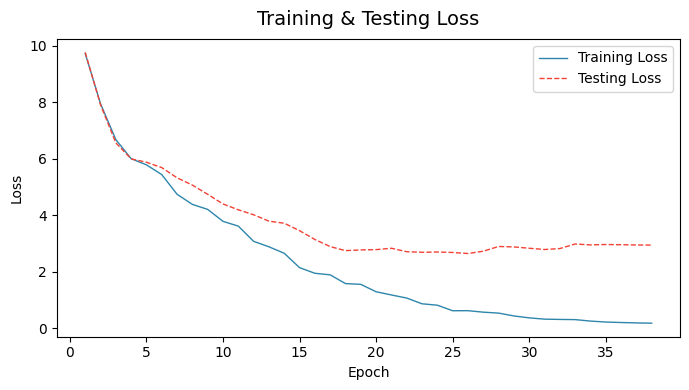

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize = (7, 4))

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label = 'Training Loss', color='#2E86AB', linewidth = 1)
plt.plot(epochs, test_losses, label = 'Testing Loss', color='#F24236', linewidth = 1, linestyle='--')

plt.title("Training & Testing Loss", fontsize = 14, pad = 10)
plt.xlabel("Epoch", fontsize = 10)
plt.ylabel("Loss", fontsize = 10)

plt.legend(frameon = True, fancybox = True)

plt.tight_layout()
plt.show()

---

### 14. LLM DECODING STRATEGIES

In [133]:
# temperature scaling

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim = 0)

In [134]:
# temperature scaling + top-k sampling

def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, 
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim = -1)

            idx_next = torch.multinomial(probs, num_samples = 1)
        
        else:
            idx_next = torch.argmax(logits, dim = -1, keepdim = True)
        
        if idx_next == eos_id:
            break
            
        idx = torch.cat((idx, idx_next), dim = 1)
    
    return idx

Text generation after applying decoding strategies.

In [142]:
torch.manual_seed(222)

token_ids = generate(
    model = model.to(device), 
    idx = text_to_token_ids("His academic journey", tokenizer).to(device),
    max_new_tokens = 65,
    context_size = GPT_CONFIG_124M["context_len"],
    top_k = 25,
    temperature = 1.4
)

print("Output:", token_ids_to_text(token_ids, tokenizer))

Output: His academic journey+, responsibly Moy Protect ALSsheet {LOmakes Euroanganpack accidental Realm deeds boards bloated backdropokes Jag vision urgentlyBritiquesux YES Journalistsiced declarationbind DPR edition tresp keyboard psychedelgradation nostalg Network websitesonde Lv retrospect editors issue265izabeth ColiseumSection DailyWoodprofessional Zimmer lawyer Pope retrospective Barclaysisse dormheimer Clyde exhilar substantially measuringificeulse


---

### 15. SAVING & LOADING MODEL WEIGHTS

In [136]:
# saving
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

In [137]:
# loading
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(512, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

It is also required to store the optimizer parameters.

In [138]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)
torch.save({
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [139]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, weight_decay = 0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(512, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

_Next: Lecture 32_